In [1]:
import sys
# load standard python modules
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib.backends.backend_pdf import PdfPages

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from modules.jet_augs import apply_single_jet_augs, translate_jets, rotate_jets, rescale_pts, distort_jets, collinear_fill_jets, crop_jets
from modules.jet_augs import shift_eta, shift_phi
from modules.transformer import Transformer
from modules.losses import contrastive_loss, align_loss, uniform_loss, contrastive_loss_num_den
from modules.perf_eval import get_perf_stats, linear_classifier_test, plot_losses
from modules.neural_net import create_and_run_nn


seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.empty_cache()


from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [2]:
# More parameters / computing setup

# set the number of threads that pytorch will use
torch.set_num_threads(2)

exp_id = "dijet_dim_scan_21_23_11/0200d/"

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)

# set up results directory
base_dir = "/global/home/users/rrmastandrea/MJetCLR/"  # change this to your working directory
expt_dir = base_dir + "projects/rep_learning/experiments/" + exp_id + "/"

#check if experiment alreadyexists
if os.path.isdir(expt_dir):
    print("ERROR: experiment already exists, don't want to overwrite it by mistake")
    pass
else:
    os.makedirs(expt_dir)

print("experiment: "+str(exp_id) , flush=True)


device: cuda
ERROR: experiment already exists, don't want to overwrite it by mistake
experiment: dijet_dim_scan_21_23_11/0200d/


# Load in the processed data

In [3]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data/"
#save_id_dir = "n_sig_8639_n_bkg_20000_n_nonzero_50_n_pad_0_n_jet_2/"
save_id_dir = "n_sig_18918_n_bkg_60000_n_nonzero_50_n_pad_0_n_jet_2/"

grading = 50
n_constits_max = 50
n_jets = 2

path_to_data = path_to_save_dir+save_id_dir
print(path_to_data)

n = 8000

clr_train = np.load(path_to_data+"clr_train.npy")[:n]
clr_val = np.load(path_to_data+"clr_val.npy")[:n]
data_train = np.load(path_to_data+"data_train.npy")[:n]
labels_train = np.load(path_to_data+"labels_train.npy")[:n]
data_val = np.load(path_to_data+"data_val.npy")[:n]
labels_val = np.load(path_to_data+"labels_val.npy")[:n]
data_test_f = np.load(path_to_data+"data_test_f.npy")[:n]
labels_test_f = np.load(path_to_data+"labels_test_f.npy")[:n]

# print data dimensions
print( "CLR training data shape: " + str( clr_train.shape ), flush=True)
print( "CLR val data shape: " + str( clr_val.shape ), flush=True)
print( "BC training data shape: " + str( data_train.shape ), flush=True)
print( "BC training labels shape: " + str( labels_train.shape ), flush=True)
print( "BC val data shape: " + str( data_val.shape ), flush=True)
print( "BC val labels shape: " + str( labels_val.shape ), flush=True)
print( "BC test data shape: " + str( data_test_f.shape ), flush=True)
print( "BC test labels shape: " + str( labels_test_f.shape ), flush=True)


# Plot num constituents

def get_num_constits(dataset):
    consits_list = []
    for collision in dataset:
        pts = collision[0,:]

        pads = np.where(pts==0)
        consits_list.append(dataset.shape[2]-len(pads[0]))
        
    return consits_list
        

/global/home/users/rrmastandrea/training_data/n_sig_18918_n_bkg_60000_n_nonzero_50_n_pad_0_n_jet_2/
CLR training data shape: (8000, 3, 102)
CLR val data shape: (6000, 3, 102)
BC training data shape: (8000, 3, 102)
BC training labels shape: (8000,)
BC val data shape: (8000, 3, 102)
BC val labels shape: (8000,)
BC test data shape: (8000, 3, 102)
BC test labels shape: (8000,)


# Define the Transformer Net

In [4]:
"""
Define the transformer net
"""

# transformer hyperparams
# input dim to the transformer -> (pt,eta,phi)
input_dim = 3
model_dim = 256
output_dim = model_dim
dim_feedforward = model_dim
n_heads = 4
n_layers = 2
n_head_layers = 2
opt = "adam"

mask= False
cmask = True

learning_rate_trans = 0.0001
batch_size = 256
temperature = .2

# augmentations
rot = True # rotations
trs = True # translations
dis = True # distortion
col = True # collinear

center = "J1_phi_only_pi_2"


net = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt )

## send network to device
net.to( device )

# define lr scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( net.optimizer, factor=0.2 )


starting training loop, running for 100 epochs with 50 constituents
Training data shape: (8000, 3, 102)
Validation data shape: (6000, 3, 102)
---
epoch: 0, loss: 5.57154
numerator: -4.176468, denominator: 9.748007
time taken up to now: 7.003132104873657

Getting the validation CLR loss...
Doing a short NN...
Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.01it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


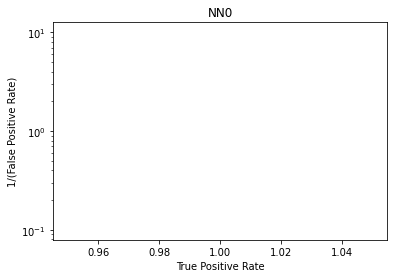

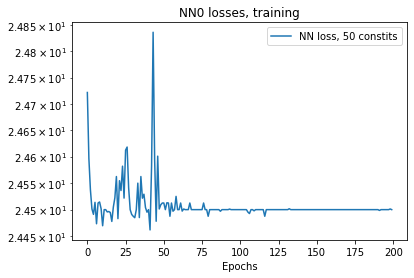

Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.00it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


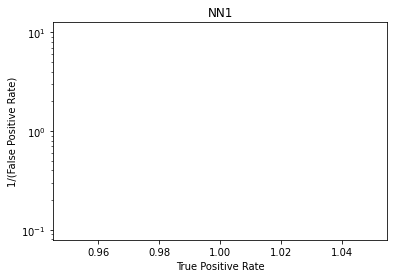

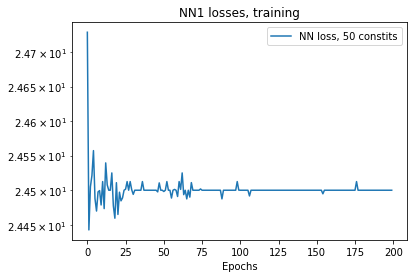

Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.11it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


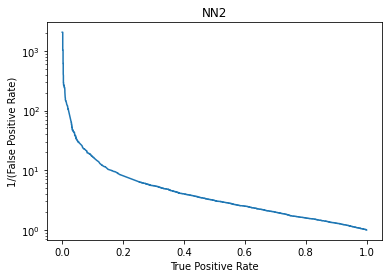

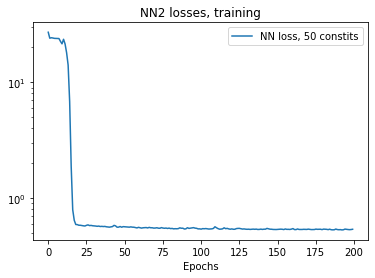

epoch: 5, loss: 5.14317
numerator: -4.127165, denominator: 9.270335
time taken up to now: 68.55054879188538

epoch: 10, loss: 5.21612
numerator: -3.9797542, denominator: 9.195871
time taken up to now: 103.70410370826721

epoch: 15, loss: 4.85231
numerator: -4.244685, denominator: 9.096997
time taken up to now: 138.7643084526062

epoch: 20, loss: 4.75647
numerator: -3.8447094, denominator: 8.601181
time taken up to now: 173.8690221309662

Getting the validation CLR loss...
Doing a short NN...
Starting training...


100%|██████████| 200/200 [00:06<00:00, 32.47it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


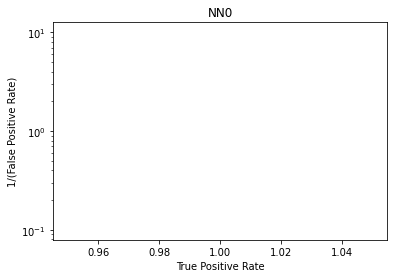

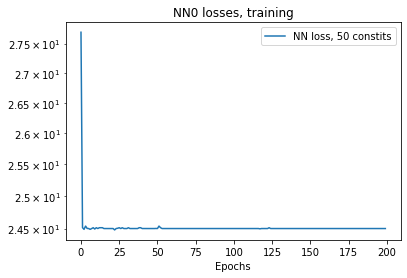

Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.93it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


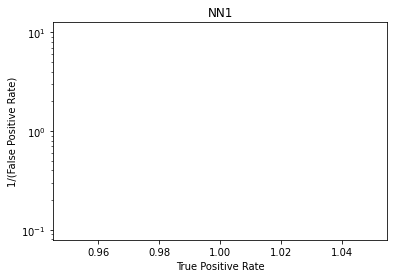

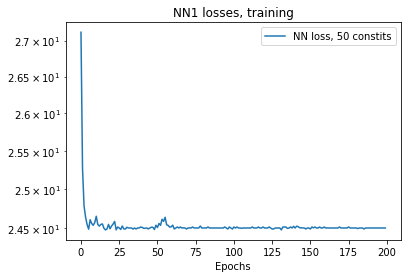

Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.61it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


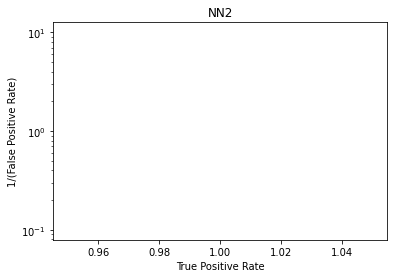

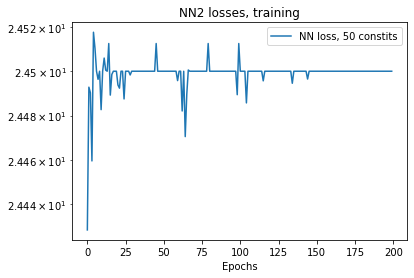

epoch: 25, loss: 4.63064
numerator: -4.1075683, denominator: 8.738209
time taken up to now: 234.58665823936462

epoch: 30, loss: 4.65704
numerator: -3.9255042, denominator: 8.582548
time taken up to now: 269.777138710022

epoch: 35, loss: 4.38961
numerator: -3.8790774, denominator: 8.268685
time taken up to now: 304.9524185657501

epoch: 40, loss: 4.36468
numerator: -3.857419, denominator: 8.222101
time taken up to now: 340.1218056678772

Getting the validation CLR loss...
Doing a short NN...
Starting training...


100%|██████████| 200/200 [00:06<00:00, 32.13it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


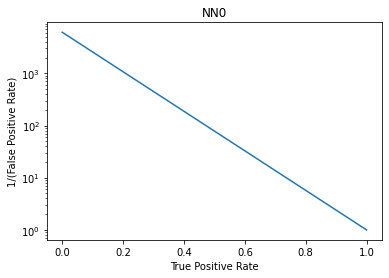

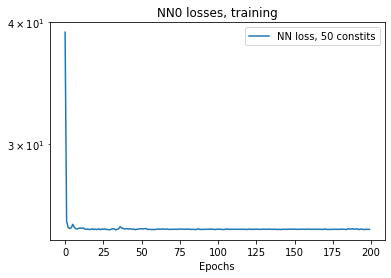

Starting training...


100%|██████████| 200/200 [00:06<00:00, 32.05it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


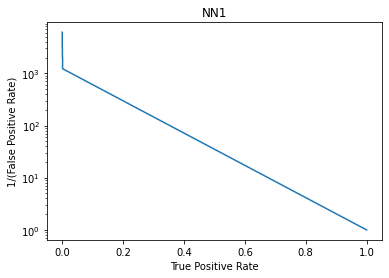

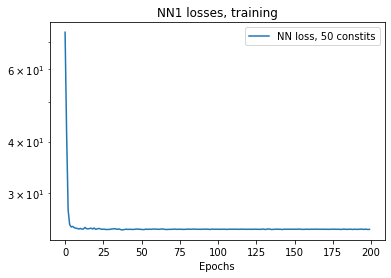

Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.92it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


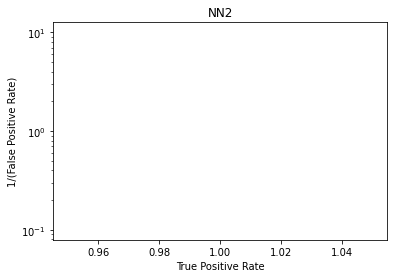

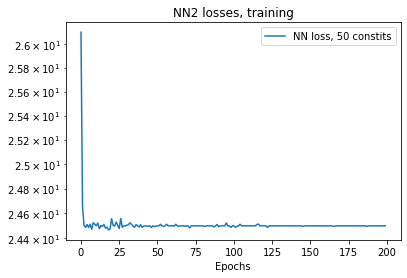

epoch: 45, loss: 4.37539
numerator: -3.9712524, denominator: 8.346638
time taken up to now: 401.10541701316833

epoch: 50, loss: 4.35926
numerator: -3.714805, denominator: 8.074066
time taken up to now: 436.3704481124878

epoch: 55, loss: 4.09404
numerator: -3.8107982, denominator: 7.9048405
time taken up to now: 471.6796188354492

epoch: 60, loss: 3.97708
numerator: -3.827234, denominator: 7.804309
time taken up to now: 506.966534614563

Getting the validation CLR loss...
Doing a short NN...
Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.80it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


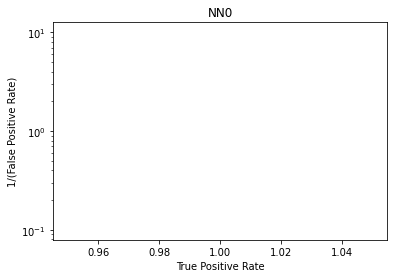

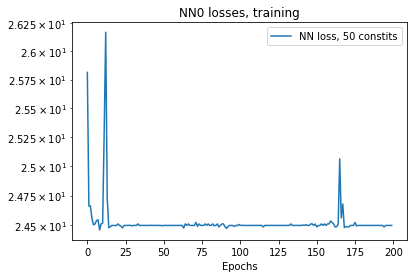

Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.52it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


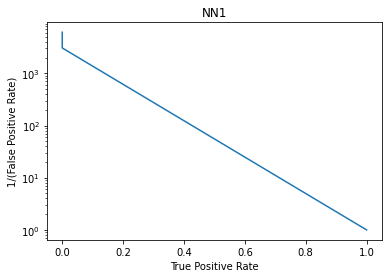

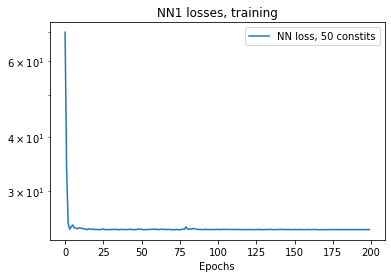

Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.62it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


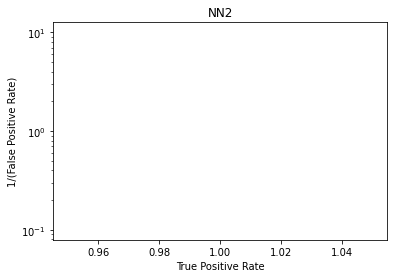

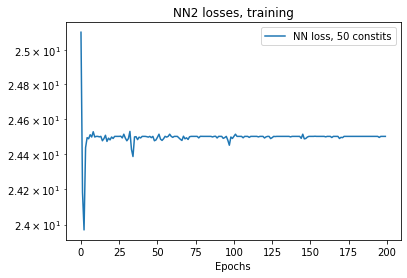

epoch: 65, loss: 3.91796
numerator: -3.8272529, denominator: 7.7452135
time taken up to now: 568.0946252346039

epoch: 70, loss: 3.89283
numerator: -3.832391, denominator: 7.7252192
time taken up to now: 603.2439262866974

epoch: 75, loss: 3.96561
numerator: -3.837822, denominator: 7.803427
time taken up to now: 638.3562407493591

epoch: 80, loss: 3.77908
numerator: -3.8354077, denominator: 7.6144896
time taken up to now: 673.4227476119995

Getting the validation CLR loss...
Doing a short NN...
Starting training...


100%|██████████| 200/200 [00:06<00:00, 32.54it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


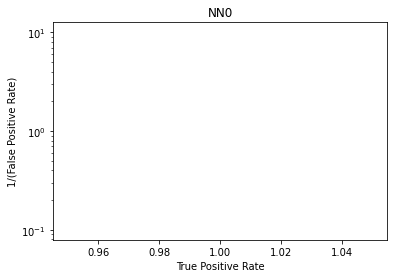

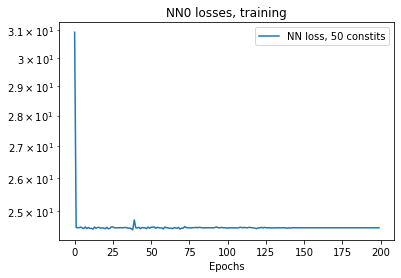

Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.43it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


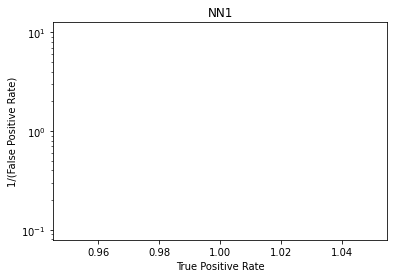

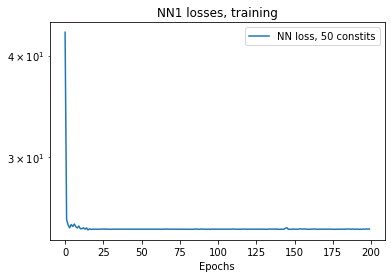

Starting training...


100%|██████████| 200/200 [00:06<00:00, 31.33it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


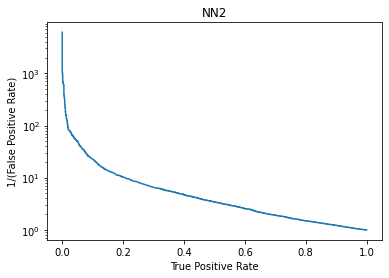

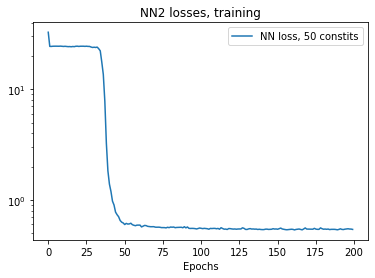

epoch: 85, loss: 3.82822
numerator: -3.918994, denominator: 7.747213
time taken up to now: 734.1595785617828

epoch: 90, loss: 3.77439
numerator: -3.9324117, denominator: 7.7068033
time taken up to now: 769.2253606319427

epoch: 95, loss: 3.63495
numerator: -3.9006844, denominator: 7.5356383
time taken up to now: 804.3047280311584

epoch: 100, loss: 3.55874
numerator: -3.8848207, denominator: 7.4435554
time taken up to now: 839.3666679859161

Getting the validation CLR loss...
Doing a short NN...
Starting training...


100%|██████████| 200/200 [00:06<00:00, 30.28it/s]
/global/home/users/rrmastandrea/computingML2/lib64/python3.6/site-packages/ipykernel_launcher.py:218: RuntimeWarning: divide by zero encountered in true_divide


Finished Training


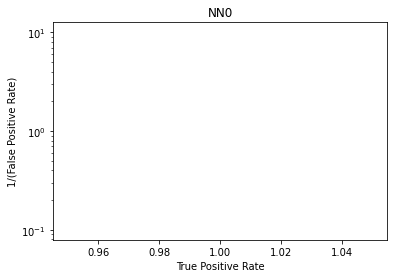

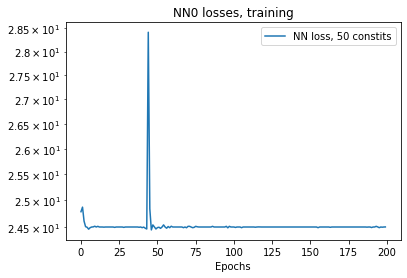

Starting training...


 68%|██████▊   | 136/200 [00:04<00:02, 31.63it/s]

In [ ]:
run_transformer = True
train_num_only = False
train_den_only = False

check_with_LCT = False
check_with_NN = True

n_epochs = 100
loss_check_epoch = 20  # do validation loss, run a LCT and NN on the current reps
verbal_epoch = 5

if run_transformer:
    
    # THE TRAINING LOOP

    # initialise lists for storing training stats, validation loss
    losses_clr_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
    loss_validation_num_jets = {i:[[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, loss
    
    losses_clr_numer_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
    losses_clr_denom_num_jets = {i:[] for i in range(grading,n_constits_max+grading,grading)}
    
    lct_auc_num_jets = {i:[[],[],[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, auc (pt, eta, phi)
    nn_auc_num_jets = {i:[[],[],[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, auc (pt, eta, phi)

    mean_consts_post_split = [] # number of constituents in the jet after collinear splitting

    for constit_num in range(grading,n_constits_max+grading,grading):

        t0 = time.time()
        print( "starting training loop, running for " + str( n_epochs ) + " epochs" + " with " + str(constit_num) + " constituents" 
              , flush=True)
        print("Training data shape:",clr_train.shape)
        print("Validation data shape:",clr_val.shape)
        print( "---", flush=True )

        # re-batch the data on each epoch
        for epoch in range( n_epochs + 1 ):
            net.optimizer.zero_grad()
            net.train()

            # get batch_size number of indices
            indices_list = torch.split( torch.randperm( clr_train.shape[0] ), batch_size )

            # initialise lists to store batch stats
            losses_clr_e = []
            losses_clr_numer_e = []
            losses_clr_denom_e = []

            # the inner loop goes through the dataset batch by batch
            # augmentations of the jets are done on the fly
            for i, indices in enumerate( indices_list ): # random jets from the dataset
                """
                TRANSFORMATIONS AND DATA PREPARATION
                """
                x_i = clr_train[indices,:,:]
                x_i, x_j = apply_single_jet_augs(x_i, 2, center, rot, trs, dis, col)
                x_j = shift_phi(x_j)
                x_j = shift_eta(x_j)

                # rescaling pT
                max_pt = np.max(x_i[:,0,:])
                pt_rescale_denom  = max_pt/ 10.
                x_i = rescale_pts( x_i, pt_rescale_denom )
                x_j = rescale_pts( x_j, pt_rescale_denom )

                mean_consts_post_split.append(np.mean(get_num_constits(x_j)))

                x_i = torch.Tensor( x_i ).transpose(1,2).to( device ) # shape (batchsize, 2, 3)
                x_j = torch.Tensor( x_j ).transpose(1,2).to( device )
                z_i = net( x_i, use_mask=mask, use_continuous_mask=cmask ) # shape (batchsize, output_dim)
                z_j = net( x_j, use_mask=mask, use_continuous_mask=cmask )

                """
                LOSS CALCULATIONS
                """            
                # compute the loss based on predictions of the net and the correct answers
                loss = contrastive_loss( z_i, z_j, device, temperature, 1 ).to( device )
                loss_numer, loss_denom = contrastive_loss_num_den( z_i, z_j, device, temperature , 1)
                
                if train_den_only:
                    loss_denom.backward()
                elif train_num_only:
                    loss_numer.backward()
                else:
                    loss.backward()
                    
                loss_numer = loss_numer.detach().cpu().numpy()
                loss_denom = loss_denom.detach().cpu().numpy()
                
                    
                net.optimizer.step()
                
                losses_clr_e.append( loss.detach().cpu().numpy() )
                losses_clr_numer_e.append(loss_numer)
                losses_clr_denom_e.append(loss_denom)

            """
            AVERAGING OF LOSSES
            """ 
            loss_clr_e = np.mean( np.array( losses_clr_e ) )
            ## scheduler
            scheduler.step( loss_clr_e )

            # storage
            losses_clr_num_jets[constit_num].append( loss_clr_e )
            losses_clr_numer_num_jets[constit_num].append( np.mean( np.array( losses_clr_numer_e ) ) )
            losses_clr_denom_num_jets[constit_num].append( np.mean( np.array( losses_clr_denom_e ) ) )

            """
            EVERY SO OFTEN, GIVEN AN UPDATE
            """

            if epoch % verbal_epoch == 0:
                

                print( "epoch: " + str( epoch ) + ", loss: " + str( round(losses_clr_num_jets[constit_num][-1], 5) ), flush=True )
                #print( "lr: " + str( scheduler._last_lr ), flush=True  )
                # summarize alignment and uniformity stats
                print( "numerator: " + str( losses_clr_numer_num_jets[constit_num][-1] ) + ", denominator: " + str( losses_clr_denom_num_jets[constit_num][-1] ), flush=True)
                print("time taken up to now: " + str(time.time()-t0))
                print()

            if epoch % loss_check_epoch == 0:
                net.eval()

                """
                Get the validation loss
                """
                print("Getting the validation CLR loss...")
                # store the epoch
                loss_validation_num_jets[constit_num][0].append(epoch)

                with torch.no_grad():

                    # get batch_size number of indices
                    indices_list_val = torch.split( torch.randperm( clr_val.shape[0] ), batch_size )
                    local_val_losses = []

                    for j, indices_val in enumerate( indices_list_val ):
                        
                        a_i = clr_val[indices_val,:,:]
                        a_i, a_j = apply_single_jet_augs(a_i, 2, center, rot, trs, dis, col)
                        a_j = shift_phi(a_j)
                        a_j = shift_eta(a_j)

                        # rescaling pT
                        max_pt = np.max(a_i[:,0,:])
                        pt_rescale_denom  = max_pt/ 10.
                        a_i = rescale_pts( a_i, pt_rescale_denom )
                        a_j = rescale_pts( a_j, pt_rescale_denom )

                        a_i = torch.Tensor( a_i ).transpose(1,2).to( device ) # shape (batchsize, 2, 3)
                        a_j = torch.Tensor( a_j ).transpose(1,2).to( device )
                        w_i = net( a_i, use_mask=mask, use_continuous_mask=cmask ) # shape (batchsize, output_dim)
                        w_j = net( a_j, use_mask=mask, use_continuous_mask=cmask )

                        loss_val = contrastive_loss( w_i, w_j, device, temperature, 1 ).to( device )
                        local_val_losses.append(loss_val.detach().cpu().numpy())

                    loss_val_e = np.mean( np.array( local_val_losses ) )
                    loss_validation_num_jets[constit_num][1].append(loss_val_e)

                if check_with_LCT:
                    """
                    Run a LCT for signal vs background (supervised)
                    """
                    #lct_train_reps = F.normalize( net.forward_batchwise( torch.Tensor( data_test_f ).transpose(1,2), data_test_f.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()
                    #lct_test_reps = F.normalize( net.forward_batchwise( torch.Tensor( data_val ).transpose(1,2), data_val.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()
                    lct_train_reps = net.forward_batchwise( torch.Tensor( data_test_f ).transpose(1,2), data_test_f.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu().numpy()
                    lct_test_reps = net.forward_batchwise( torch.Tensor( data_val ).transpose(1,2), data_val.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu().numpy()

                    print("Doing a short LCT...")

                    lct_auc_num_jets[constit_num][0].append(epoch)
                    with torch.no_grad():
                        for trait in range(lct_train_reps.shape[1]): # going through the layers of the transformer
                            # run the LCT
                            reg = LinearRegression().fit(lct_train_reps[:,trait,:], labels_test_f)
                            # make the prediction
                            predictions = reg.predict(lct_test_reps[:,trait,:])
                            auc = roc_auc_score(labels_val, predictions)
                            lct_auc_num_jets[constit_num][1+trait].append(auc)
                            
                
                if check_with_NN:
                    """
                    Run a NN for signal vs background (supervised)
                    """
                    
                    #lct_train_reps = F.normalize( net.forward_batchwise( torch.Tensor( data_test_f ).transpose(1,2), data_test_f.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()
                    #lct_test_reps = F.normalize( net.forward_batchwise( torch.Tensor( data_val ).transpose(1,2), data_val.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()
                    lct_train_reps = net.forward_batchwise( torch.Tensor( data_test_f ).transpose(1,2), data_test_f.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu().numpy()
                    lct_test_reps = net.forward_batchwise( torch.Tensor( data_val ).transpose(1,2), data_val.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu().numpy()

                    print("Doing a short NN...")
                    num_epochs_nn = 200
                    batch_size_nn = 400
                    update_epochs_nn = 2*num_epochs_nn # no validation
                    input_shape = model_dim
                    lr_nn = 0.0001

                    nn_auc_num_jets[constit_num][0].append(epoch)
                    # we need the grad turned on to train the nn
                    for trait in range(lct_train_reps.shape[1]): # going through the layers of the transformer
                        # run the NN
                        performance_stats_nn = create_and_run_nn(device, input_shape, num_epochs_nn, batch_size_nn, 
                                                                 update_epochs_nn,lr_nn, 
                                                                  lct_train_reps[:,trait,:], labels_test_f, 
                                                                  lct_train_reps[:,trait,:], labels_test_f, # actually no validation set
                                                                  lct_test_reps[:,trait,:], labels_val, True)



                        nn_auc_num_jets[constit_num][1+trait].append(performance_stats_nn["auc"])

                        plt.figure()
                        plt.plot(performance_stats_nn["tpr"], 1.0/performance_stats_nn["fpr"])
                        plt.yscale("log")
                        plt.xlabel("True Positive Rate")
                        plt.ylabel("1/(False Positive Rate)")
                        plt.title("NN"+str(trait))
                        plt.show()


                        plot_nn_losses = []
                        plot_nn_losses.append((performance_stats_nn["epochs"],
                                           performance_stats_nn["losses"], "NN loss, "+str(constit_num) + " constits"))
                        fig = plot_losses(plot_nn_losses, "NN"+str(trait)+" losses, training", True)  




                            

        t1 = time.time()

        print( "JETCLR TRAINING DONE, time taken: " + str( np.round( t1-t0, 2 ) ), flush=True)


        # save out results
        print( "saving out data/results", flush=True)
        np.save( expt_dir+"clr_losses_train_"+str(constit_num)+".npy", losses_clr_num_jets[constit_num] )
        np.save( expt_dir+"clr_losses_val_"+str(constit_num)+".npy", loss_validation_num_jets[constit_num] )
        np.save( expt_dir+"clr_numer_loss_train_"+str(constit_num)+".npy", losses_clr_numer_num_jets[constit_num] )
        np.save( expt_dir+"clr_denom_loss_train_"+str(constit_num)+".npy", losses_clr_denom_num_jets[constit_num] )
        
        np.save( expt_dir+"lct_auc_"+str(constit_num)+".npy", lct_auc_num_jets[constit_num] )
        np.save( expt_dir+"nn_auc_"+str(constit_num)+".npy", nn_auc_num_jets[constit_num] )

        # save out final trained model
        print( "saving out final jetCLR model", flush=True )
        torch.save(net.state_dict(), expt_dir+"final_model_"+str(constit_num)+".pt")
        print()

        print("Avg # constits:", np.mean(mean_consts_post_split))


In [ ]:
losses_pdf_name = expt_dir + "CLR_training_losses.pdf"
pp = PdfPages(losses_pdf_name)


"""
Plot the training contrastive losses
"""
plot_clr_losses = []

plot_clr_losses.append((range(len(losses_clr_num_jets[constit_num])),
                       losses_clr_num_jets[constit_num], "CLR loss, "+str(constit_num) + " constits"))
plot_clr_losses.append((loss_validation_num_jets[constit_num][0],
                       loss_validation_num_jets[constit_num][1],"Val loss, "+str(constit_num) + " constits"))
fig = plot_losses(plot_clr_losses, "Contrastive losses, training", True)  

pp.savefig(fig)
    
"""
Plot the LC + NN AUC
"""

plot_LCT_stats = []
plot_LCT_stats.append((lct_auc_num_jets[constit_num][0], lct_auc_num_jets[constit_num][1],
                         "LC transformer, "+str(constit_num) + " constits"))
plot_LCT_stats.append((lct_auc_num_jets[constit_num][0], lct_auc_num_jets[constit_num][2],
                        "LC hidden layer, "+str(constit_num) + " constits"))
plot_LCT_stats.append((lct_auc_num_jets[constit_num][0], lct_auc_num_jets[constit_num][3],
                        "LC output layer, "+str(constit_num) + " constits"))

fig = plot_losses(plot_LCT_stats, "ROC Area", False)  
pp.savefig(fig)

plot_NN_stats = []
plot_NN_stats.append((nn_auc_num_jets[constit_num][0], nn_auc_num_jets[constit_num][1],
                         "NN transformer, "+str(constit_num) + " constits"))
plot_NN_stats.append((nn_auc_num_jets[constit_num][0], nn_auc_num_jets[constit_num][2],
                        "NN hidden layer, "+str(constit_num) + " constits"))
plot_NN_stats.append((nn_auc_num_jets[constit_num][0], nn_auc_num_jets[constit_num][3],
                        "NN output layer, "+str(constit_num) + " constits"))

fig = plot_losses(plot_NN_stats, "ROC Area", False)  
pp.savefig(fig)
    
"""
Plot the training contrastive losses num + denom
"""

plot_num_val_losses = []
plot_num_val_losses.append((range(len(losses_clr_numer_num_jets[constit_num])),
                       -np.array(losses_clr_numer_num_jets[constit_num]), str(constit_num) + " constits"))
fig = plot_losses(plot_num_val_losses, "-Alignment losses (should increase)", True)  
pp.savefig(fig)

plot_den_val_losses = []
plot_den_val_losses.append((range(len(losses_clr_denom_num_jets[constit_num])),
                       np.array(losses_clr_denom_num_jets[constit_num]),  str(constit_num) + " constits"))
fig = plot_losses(plot_den_val_losses, "Uniformity losses (should decrease)", True)  
pp.savefig(fig)

    
pp.close()

# Run final LCT on the transformer representations

In [ ]:
constit_num = grading
n_constits_max = grading


# Loading in the final transformer

loaded_net = Transformer( input_dim, model_dim, output_dim, n_heads, dim_feedforward, 
                  n_layers, learning_rate_trans, n_head_layers, dropout=0.1, opt=opt )

loaded_net.load_state_dict(torch.load(expt_dir+"final_model_"+str(constit_num)+".pt"))
loaded_net.eval()


In [ ]:
# Running the final transformer on the binary classification data

print("Loading data into net...")
#lct_train_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( data_train ).transpose(1,2), data_train.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()
#lct_test_reps = F.normalize( loaded_net.forward_batchwise( torch.Tensor( data_test_f ).transpose(1,2), data_test_f.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu(), dim=-1  ).numpy()

lct_train_reps = loaded_net.forward_batchwise( torch.Tensor( data_train ).transpose(1,2), data_train.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu().numpy()
lct_val_reps =  loaded_net.forward_batchwise( torch.Tensor( data_val ).transpose(1,2), data_val.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu().numpy()
lct_test_reps =  loaded_net.forward_batchwise( torch.Tensor( data_test_f ).transpose(1,2), data_test_f.shape[0], use_mask=mask, use_continuous_mask=cmask ).detach().cpu().numpy()

print("Data loaded!")



In [ ]:


LCT_pdf_name = expt_dir + "LCT_plots.pdf"
pp = PdfPages(LCT_pdf_name)



fig = plt.figure()

print("Doing a LCT...")
# Need to transform the data into the representation space first
with torch.no_grad():
    for trait in range(lct_train_reps.shape[1]): # going through the layers of the transformer
        # run the LCT

       
        reg = LinearRegression().fit(lct_train_reps[:,trait,:], labels_train)
        # make the prediction
        predictions = reg.predict(lct_test_reps[:,trait,:])
        fpr, tpr, _ = roc_curve(labels_test_f, predictions)
        
        plt.plot(tpr, 1.0/fpr, label = "LCT"+str(trait))
        
        np.save( expt_dir+"CLR_LCT"+str(trait)+"_fpr_"+str(constit_num)+".npy", fpr )
        np.save( expt_dir+"CLR_LCT"+str(trait)+"_tpr_"+str(constit_num)+".npy", tpr )
        
        
        
        
        predicted = np.round(predictions).reshape(labels_test_f.size)
        total = labels_test_f.size
        correct = (predicted == labels_test_f).sum()    
        
        print("CLR_LCT"+str(trait),"acc:",correct/total)
        
        

plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.legend()
plt.show()

pp.savefig(fig)
pp.close()

        
print("LCT data saved")






# Run final NN on the transformer representations

In [ ]:


num_epochs_nn = 400
batch_size_nn = 400
update_epochs_nn = 5
input_shape = model_dim
lr_nn = 0.0001


    

NN_pdf_name = expt_dir + "NN_plots.pdf"
pp = PdfPages(NN_pdf_name)


#plt.figure()

print("Doing a NN...")
# Need to transform the data into the representation space first
#with torch.no_grad():
for trait in range(lct_train_reps.shape[1]): # going through the layers of the transformer
    
    # make dictionaries to stre the losses
    losses_nn_latent_train = {i:[] for i in range(grading,n_constits_max+grading,grading)}
    losses_nn_latent_val = {i:[[],[]] for i in range(grading,n_constits_max+grading,grading)} #epoch, loss

    # run the NN
    performance_stats_nn = create_and_run_nn(device, input_shape, num_epochs_nn, batch_size_nn, update_epochs_nn,lr_nn, 
                                     lct_train_reps[:,trait,:], labels_train, 
                  lct_val_reps[:,trait,:], labels_val,
                  lct_test_reps[:,trait,:], labels_test_f, True)

    #plt.plot(performance_stats_nn["tpr"], 1.0/performance_stats_nn["fpr"], label = "NN"+str(trait))
    
    np.save( expt_dir+"CLR_NN"+str(trait)+"_fpr_"+str(constit_num)+".npy", performance_stats_nn["fpr"] )
    np.save( expt_dir+"CLR_NN"+str(trait)+"_tpr_"+str(constit_num)+".npy", performance_stats_nn["tpr"] )

    print("Accuracy of the network: %d %%" % (100.00 *performance_stats_nn["acc"]))
    print("ROC AUC:", performance_stats_nn["auc"])
    
    
    plot_nn_losses = []
    plot_nn_losses.append((performance_stats_nn["epochs"],
                       performance_stats_nn["losses"], "NN loss, "+str(constit_num) + " constits"))
    plot_nn_losses.append((performance_stats_nn["val_epochs"],
                       performance_stats_nn["val_losses"],"Val loss, "+str(constit_num) + " constits"))
    fig = plot_losses(plot_nn_losses, "NN losses, training", True)  
    pp.savefig(fig)
    
    
    # Save out the losses dictionaries
    losses_nn_latent_train[constit_num] = performance_stats_nn["losses"]
    losses_nn_latent_val[constit_num][0] = performance_stats_nn["val_epochs"]
    losses_nn_latent_val[constit_num][1] = performance_stats_nn["val_losses"]
    
    np.save( expt_dir+"NN"+str(trait)+"_latent_losses_train_"+str(constit_num)+".npy", losses_nn_latent_train[constit_num] )
    np.save( expt_dir+"NN"+str(trait)+"_latent_losses_val_"+str(constit_num)+".npy", losses_nn_latent_val[constit_num] )
    

#plt.yscale("log")
#plt.xlabel("True Positive Rate")
#plt.ylabel("1/(False Positive Rate)")
#plt.legend()
#plt.show()


pp.close()


print("NN data saved")






    
